In [2]:
import os
import sys
from httpx import AsyncClient
import re
import json
import asyncio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
module_path = os.path.abspath(os.path.join('../transfermarket/'))
sys.path.append(module_path)

In [4]:
client=AsyncClient()

In [5]:
next_delay = 0

async def delayed_fetch(url:str,match_date:str,sleep_time_seconds:int = 3):
    global next_delay
    # need to increase the delay on each api request 
    # (since they all start the timers simulataneously)
    next_delay += sleep_time_seconds
    await asyncio.sleep(next_delay)
    
    print(".", end="")
    fetch = await client.get(url)
    # need to keep track of which match this is so we can add metadata
    # e.g. opponent name, match result
    return match_date, fetch

In [6]:
from httpx import Response

nunez_player_id = "4d77b365"

async def get_match_data(player_id:str, season:str = '2022-2023')-> dict[str, dict[str,str]]:
    match_summary_url = f"https://fbref.com/en/players/{player_id}/matchlogs/{season}/summary/"

    match_page = await client.get(match_summary_url)
    matches = pd.read_html(match_page.content ,extract_links="all")[0].iloc[:, [0,4,5,6,7,-1]]
    matches.columns = [(col[1][0]) for col in matches.columns] #type:ignore
    # remove links for everything but match report
    matches.iloc[:, :-1] = matches.iloc[:, :-1].applymap(lambda x:x[0])
    matches.iloc[:, -1] = matches.iloc[:, -1].apply(lambda x:x[-1])

    match_dates:dict[str, dict] = matches.dropna().set_index('Date').to_dict('index') #type:ignore
    return match_dates

async def get_all_shots(match_dates:dict[str, dict[str,str]]):
    fetch_coros = []
    next_delay = 0

    async def delayed_fetch(url:str,match_date:str,sleep_time_seconds:int = 3)->tuple[str,Response]:
        nonlocal next_delay
        # need to increase the delay on each api request 
        # (since they all start the timers simulataneously)
        next_delay += sleep_time_seconds
        await asyncio.sleep(next_delay)
        
        print(".", end="")
        fetch = await client.get(url)
        # need to keep track of which match this is so we can add metadata
        # e.g. opponent name, match result
        return match_date, fetch

    for date, match_details in match_dates.items():
        match_url = match_details['Match Report']
        fetch_coros.append(delayed_fetch(f"https://fbref.com/{match_url}", date))

    match_pages = await asyncio.gather(*fetch_coros)
    return match_pages

def process_shot_data(match_pages:tuple[str,Response]):
    match_data =[]
    for match_date, data in match_pages:
        res_dfs = pd.read_html(data.content)

        longest_xg_df = 0
        xg_df = None
        #we need to find xg table with most entries (to ensure we arent picking a filtered table)
        for df in res_dfs:
            try:
                if 'xG' in df.droplevel(level=0, axis=1).columns:
                    if len(df) > longest_xg_df:
                        longest_xg_df = len(df)
                        xg_df = df
            except ValueError:
                # we cant drop level so this isnt an xg table
                continue
    
        if xg_df is None:
            # no xg data available for this game
            continue
        shot_data = xg_df.iloc[:,[0,1,3,5] ]
        shot_data= shot_data.droplevel(0, axis=1)
        shot_data['date'] = match_date
        match_data.append(shot_data)
        
    all_matches = pd.concat(match_data)
    return all_matches

In [8]:
player_ids = {
    "kane":"21a66f6a", 
    "haaland":"1f44ac21", 
    "firmino": "4c370d81", 
    "salah": "e342ad68", 
    "nunez": "4d77b365",
    "gakpo": "1971591f",
    "jota": "178ae8f8", 
    "diaz":"4a1a9578"
    }


for player, player_id in player_ids.items():
    print(f"grabbing {player} data")
    shot_data = []
    match_data = []

    for season in ["2020-2021","2021-2022","2022-2023"]:
        print(season)
        matches = await get_match_data(player_id, season=season)
        match_data.append(matches)
        shots = await get_all_shots(matches)
        processed_shots = process_shot_data(shots)
        shot_data.append(processed_shots)

    all_shot_data = pd.concat(shot_data).to_csv(f"{player}_shot_data.csv")
    all_match_data = pd.concat([pd.DataFrame.from_dict(match, orient='index') for match in match_data]).to_csv(f"{player}_match_data.csv")

grabbing salah data
2020-2021
.....................................................2021-2022
..................................................................2022-2023
............................

## Plotting

In [137]:

players = {
    'Cody Gakpo': 'gakpo',
    'Luis Díaz': 'diaz',
    'Diogo Jota': 'jota',
    'Mohamed Salah': 'salah',
    'Roberto Firmino': 'firmino',
    'Darwin Núñez':'nunez'
    }
dfs =[]

for player_name, shortname in players.items():
    match_shots = pd.read_csv(f"{shortname}_shot_data.csv")
    matches = pd.read_csv(f"{shortname}_match_data.csv")

    match_shots.dropna(subset=['Player','xG'], inplace=True)
    match_shots['Player'] = match_shots['Player'].apply(lambda x:x.split(" (pen)")[0])
    matches.set_index('Unnamed: 0', inplace=True)
    match_shots.set_index('date', inplace=True)
    match_shots = match_shots.join(matches, how='left')
    match_shots = match_shots[match_shots['Player']==player_name]

    match_shots['date'] = match_shots.index
    dfs.append(match_shots)

In [138]:
concat_shots = pd.concat(dfs).loc[:,['Minute', 'Player', 'xG', 'Outcome', 'Venue', 'Result', 'Squad', 'Opponent']]
concat_shots = concat_shots.dropna(axis=0).drop_duplicates()

In [139]:
concat_shots = concat_shots.assign(is_goal=concat_shots['Outcome']=='Goal')
player_goals = concat_shots[concat_shots['is_goal']]

In [140]:
median_goal_xg = player_goals.groupby('Player').median(numeric_only=True).reset_index()

player_xg_order = median_goal_xg.sort_values('xG')['Player'].to_list()

import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['font.family'] = 'JetBrains Mono'
fig, ax = plt.subplots(figsize=(20,10))


sns.stripplot(concat_shots[concat_shots['is_goal']==False],x= 'xG', y='Player', ax=ax, alpha=0.3, s=10, color='grey', order= player_xg_order)
sns.stripplot(concat_shots[concat_shots['is_goal']==True],x= 'xG', y='Player', ax=ax, s=10, color='red', order= player_xg_order)

ax.tick_params(length=0)
ax.set_title("Expected Goals (xG) of shots since 2020/2021*", loc="left", pad=80, fontdict={'size':30})
ax.set_ylabel("")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
ax.legend(handles = [ 
                Line2D([0], [0], marker='o', color='r', label='Goal', linewidth=0,
                        markersize=15),
                Line2D([0], [0], color='#1f77b4', label='Avg goal xG', linewidth=4,alpha =0.5,
                        markersize=15)
                    ], 
                    frameon=False, 
                    fontsize=16, 
                    loc='upper center',
                    ncol=2,
                    bbox_to_anchor=(0.5,1.08)
            )
data_disclaimer = "*xG data is not available for all competitions"
_ = plt.gcf().text(0.05, 0.0, data_disclaimer, fontsize=14, fontdict={'color':  'black'}, ha="left")
_ = plt.gcf().text(0.9, 0.00, "ismailmo.com", fontsize=18, fontdict={'color':  'blue'}, ha="right")
_ = plt.gcf().text(0.9, -0.02, "data: fbref.com", fontsize=14.25, fontdict={'color':  'blue'}, ha="right")

# add avg goal xG line
tick_label_order = [label._text for label in ax.get_yticklabels()]
annotation_pos = [(idx,median_goal_xg[median_goal_xg['Player']==tick]['xG'].squeeze()) for idx, tick in enumerate(tick_label_order)]

num_y_labels = len(annotation_pos)
for y,x in annotation_pos:
    y_loc = 1- (y/num_y_labels)
    y_width = 1/num_y_labels
    line_height = 1/(num_y_labels+1)

    ax.axvline(x,ymin = y_loc-line_height, ymax = y_loc - y_width + line_height, color='#1f77b4', linewidth = 4, alpha=0.5)
    offset = 10
    ax.annotate(f"{x:.2f}", (x,y), xytext=(offset/2, 2*offset), textcoords='offset points')


ax.tick_params(axis='y', which='major', labelsize=15)
ax.xaxis.label.set_fontsize(16)

for idx, label in enumerate(tick_label_order):
        num_shots = len(concat_shots[concat_shots['Player']==label])
        num_goals = len(player_goals[player_goals['Player']==label])
        shots_per_goal = num_shots/num_goals
        ax.annotate(f"shots: {num_shots}\ngoals: {num_goals}\nshots/goal: {shots_per_goal:.2f}", 
                xy=(-0.05,idx + 0.33), xycoords='data', annotation_clip=False, horizontalalignment='right')

_ = ax.set_yticklabels(ax.get_yticklabels(), va='bottom')

## Add more contextual data with plotly

In [142]:
concat_shots = concat_shots.reset_index().rename({'index':'date'}, axis=1)
concat_shots.sample(5)

,date,Minute,Player,xG,Outcome,Venue,Result,Squad,Opponent,is_goal
1356,2022-09-03,19,Darwin Núñez,0.06,Off Target,Away,D 0–0,Liverpool,Everton,False
711,2021-04-14,68,Mohamed Salah,0.08,Blocked,Home,D 0–0,eng Liverpool,es Real Madrid,False
169,2022-09-11,42,Cody Gakpo,0.10,Woodwork,Home,W 1–0,PSV Eindhoven,RKC Waalwijk,False
808,2021-12-01,8,Mohamed Salah,0.19,Saved,Away,W 4–1,Liverpool,Everton,False
1368,2022-10-04,41,Darwin Núñez,0.34,Saved,Home,W 2–0,eng Liverpool,sct Rangers,False


In [143]:
import plotly.graph_objects as go
fig = px.strip(
    concat_shots, 
    x='xG',
    y='Player',
    color='is_goal',
    color_discrete_sequence=['rgba(255, 0, 0, 0.3)', 'rgba(0, 0, 0, 0.3)'],
    width=2000,
    height=1000,
    stripmode='group',
    range_x=[0,1],
    hover_data= {
        'date':True,
        'Minute': True,
        'is_goal':False,
        'Player': False,
        'xG': True,
        'Outcome': True,
        'Venue': True,
        'Result': True,
        'Squad': True,
        'Opponent': True,
    },
    title="Expected goals (xG) of shots from Liverpool's forwards"
    )

fig.update_layout(font_family='JetBrains Mono', title_font_size = 42, legend_orientation="h", legend_x = 0.5, legend_xanchor="center", legend_y=1, legend_yanchor="bottom")
fig.update_yaxes(title="", tickfont={"size":16} )
fig.update_xaxes(title_font_size=32)
fig.for_each_trace(lambda t: t.update({"marker":{"size":10}}))

In [144]:
concat_shots['Squad'] = concat_shots['Squad'].apply(lambda x:x.split(" ")[-1])

## How about just shots at Liverpool?

In [152]:
lpool_shots = concat_shots[concat_shots['Squad']=='Liverpool']

In [153]:
lpool_shots.sample(5)

,date,Minute,Player,xG,Outcome,Venue,Result,Squad,Opponent,is_goal
584,2022-05-22,15,Diogo Jota,0.12,Blocked,Home,W 3–1,Liverpool,Wolves,False
1085,2021-05-13,45+3,Roberto Firmino,0.15,Goal,Away,W 4–2,Liverpool,Manchester Utd,True
628,2020-11-03,47.0,Mohamed Salah,0.10,Goal,Away,W 5–0,Liverpool,it Atalanta,True
1164,2022-10-19,64,Roberto Firmino,0.09,Saved,Home,W 1–0,Liverpool,West Ham,False
412,2022-09-13,61.0,Luis Díaz,0.02,Blocked,Home,W 2–1,Liverpool,nl Ajax,False


/tmp/ipykernel_10769/1311343124.py:67: UserWarning:

FixedFormatter should only be used together with FixedLocator



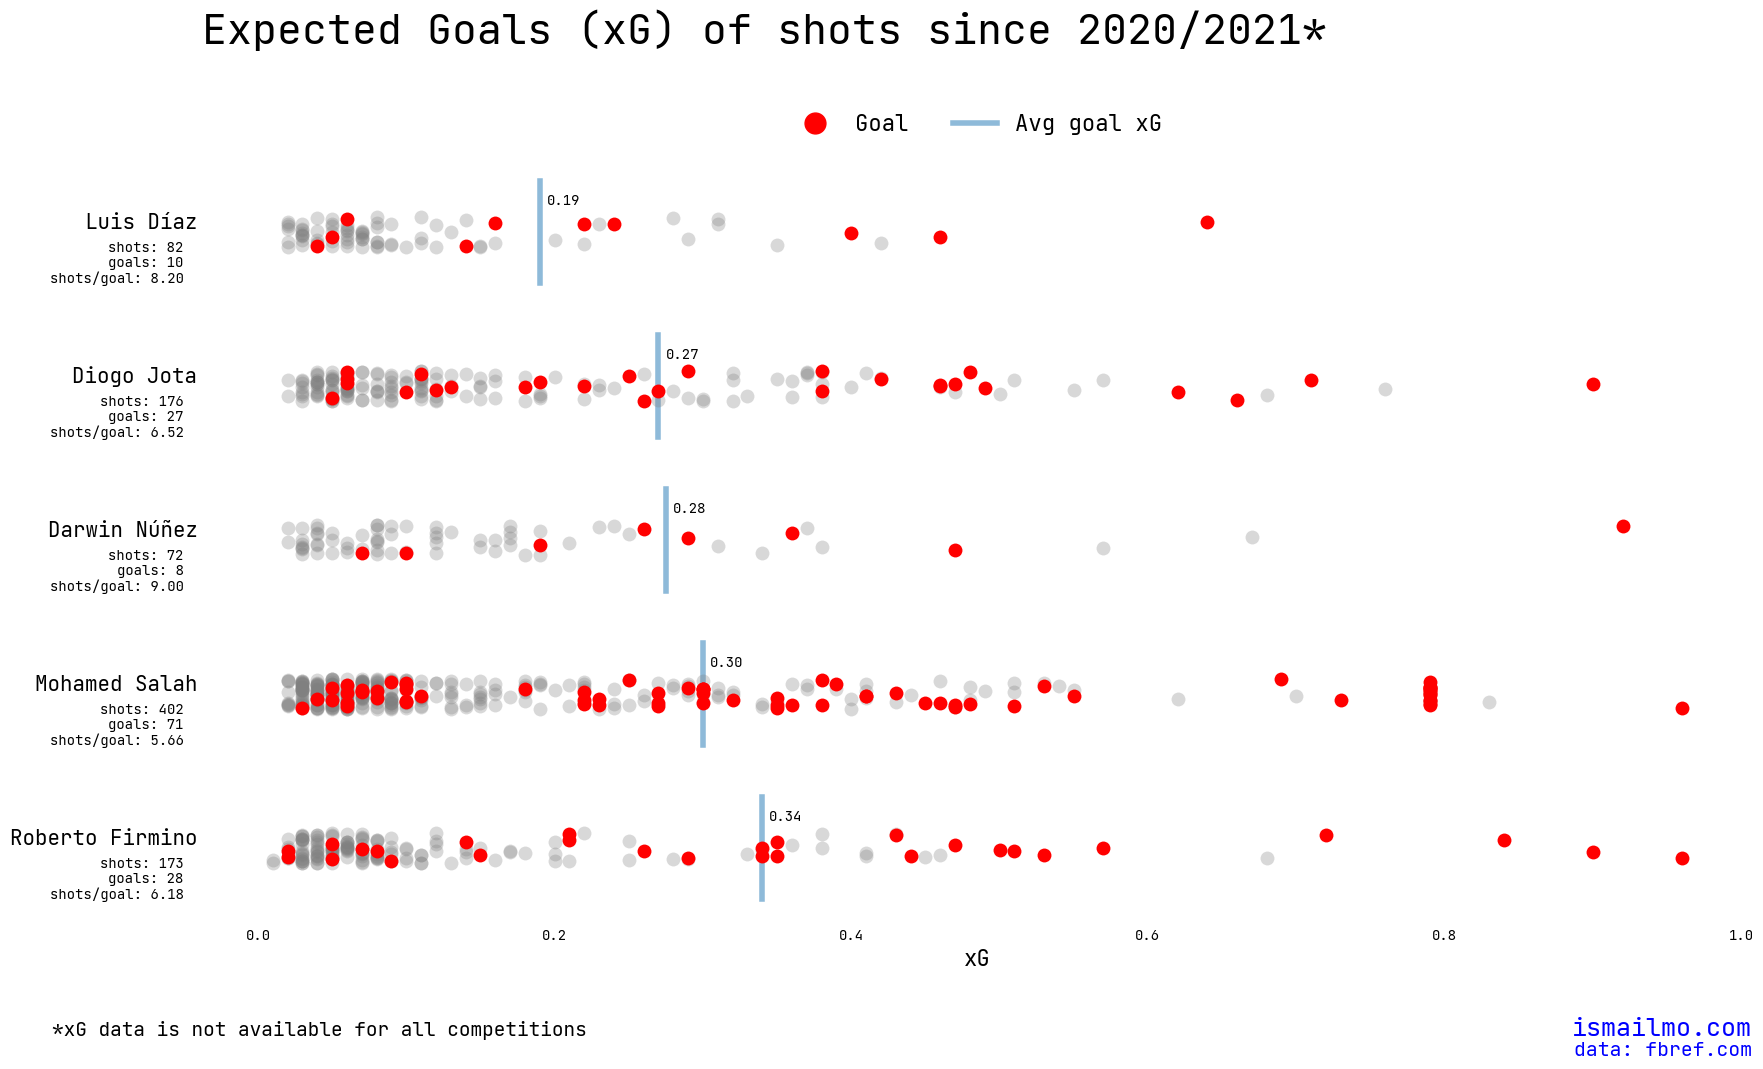

In [157]:
lpool_goals = lpool_shots[lpool_shots["is_goal"]==True]
median_goal_xg = lpool_goals.groupby('Player').median(numeric_only=True).reset_index()

player_xg_order = median_goal_xg.sort_values('xG')['Player'].to_list()

import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['font.family'] = 'JetBrains Mono'
fig, ax = plt.subplots(figsize=(20,10))


sns.stripplot(lpool_shots[lpool_shots['is_goal']==False],x= 'xG', y='Player', ax=ax, alpha=0.3, s=10, color='grey', order= player_xg_order)
sns.stripplot(lpool_shots[lpool_shots['is_goal']==True],x= 'xG', y='Player', ax=ax, s=10, color='red', order= player_xg_order)

ax.tick_params(length=0)
ax.set_title("Expected Goals (xG) of shots since 2020/2021*", loc="left", pad=80, fontdict={'size':30})
ax.set_ylabel("")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
ax.legend(handles = [ 
                Line2D([0], [0], marker='o', color='r', label='Goal', linewidth=0,
                        markersize=15),
                Line2D([0], [0], color='#1f77b4', label='Avg goal xG', linewidth=4,alpha =0.5,
                        markersize=15)
                    ], 
                    frameon=False, 
                    fontsize=16, 
                    loc='upper center',
                    ncol=2,
                    bbox_to_anchor=(0.5,1.08)
            )
data_disclaimer = "*xG data is not available for all competitions"
_ = plt.gcf().text(0.05, 0.0, data_disclaimer, fontsize=14, fontdict={'color':  'black'}, ha="left")
_ = plt.gcf().text(0.9, 0.00, "ismailmo.com", fontsize=18, fontdict={'color':  'blue'}, ha="right")
_ = plt.gcf().text(0.9, -0.02, "data: fbref.com", fontsize=14.25, fontdict={'color':  'blue'}, ha="right")

# add avg goal xG line
tick_label_order = [label._text for label in ax.get_yticklabels()]
annotation_pos = [(idx,median_goal_xg[median_goal_xg['Player']==tick]['xG'].squeeze()) for idx, tick in enumerate(tick_label_order)]

num_y_labels = len(annotation_pos)
for y,x in annotation_pos:
    y_loc = 1- (y/num_y_labels)
    y_width = 1/num_y_labels
    line_height = 1/(num_y_labels+1)

    ax.axvline(x,ymin = y_loc-line_height, ymax = y_loc - y_width + line_height, color='#1f77b4', linewidth = 4, alpha=0.5)
    offset = 10
    ax.annotate(f"{x:.2f}", (x,y), xytext=(offset/2, 2*offset), textcoords='offset points')


ax.tick_params(axis='y', which='major', labelsize=15)
ax.xaxis.label.set_fontsize(16)

for idx, label in enumerate(tick_label_order):
        num_shots = len(lpool_shots[lpool_shots['Player']==label])
        num_goals = len(lpool_goals[lpool_goals['Player']==label])
        shots_per_goal = num_shots/num_goals
        ax.annotate(f"shots: {num_shots}\ngoals: {num_goals}\nshots/goal: {shots_per_goal:.2f}", 
                xy=(-0.05,idx + 0.33), xycoords='data', annotation_clip=False, horizontalalignment='right')

_ = ax.set_yticklabels(ax.get_yticklabels(), va='bottom')